In [1]:
import numpy as np
import linmix

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns; sns.set(color_codes=True)

# Debug Linmix

Here I investigate how much can I trust the intrisec scatter output by linmix in the context of the mu-star mass relation.

## Make X

In [2]:
np.random.seed(42)
xupper = np.random.uniform(13.5, 15.0, size=1000)

prob = np.exp(-(xupper-14.5)/0.20)
prob = np.where(xupper<=14.5, 1., prob)
idx = np.random.choice(1000, size=2700, p=prob/np.sum(prob))
x = xupper[idx]

In [3]:
Mp = 10.**15.5
xn = np.log10(10**x/Mp)

(array([331., 393., 270., 314., 289., 301., 335., 233., 126.,  73.,  35.]),
 array([13.50694803, 13.64264153, 13.77833503, 13.91402853, 14.04972203,
        14.18541552, 14.32110902, 14.45680252, 14.59249602, 14.72818951,
        14.86388301, 14.99957651]),
 <a list of 11 Patch objects>)

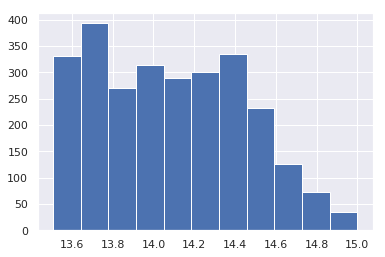

In [4]:
plt.hist(x, bins=11)

(array([371., 407., 311., 374., 261., 368., 312., 163.,  92.,  41.]),
 array([-1.99305197, -1.84378912, -1.69452627, -1.54526342, -1.39600058,
        -1.24673773, -1.09747488, -0.94821203, -0.79894919, -0.64968634,
        -0.50042349]),
 <a list of 10 Patch objects>)

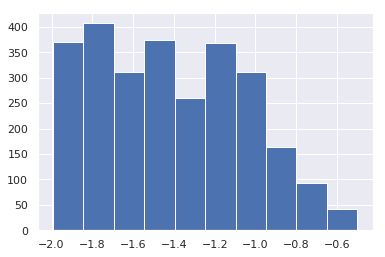

In [5]:
plt.hist(xn)

## Make Y 

In [6]:
print('2 %% of Stellar Mass out of A Big Halo')
print(np.log10(0.02*10**15.5))

print('Taking into consideration the ICM we will assume just one percent')
print(np.log10(0.01*10**15.5))

2 %% of Stellar Mass out of A Big Halo
13.801029995663981
Taking into consideration the ICM we will assume just one percent
13.5


In [7]:
alpha, slope = 13.5, 0.90
intScatter = 0.2

mu_fake = alpha + slope*xn + np.random.normal(scale=intScatter,size=len(xn))

Text(0,0.5,'Log Mu-Star')

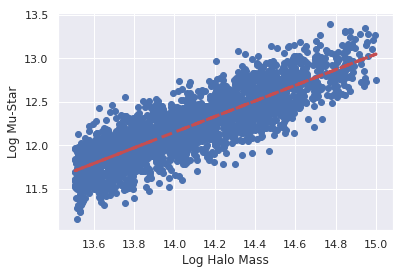

In [8]:
plt.scatter(x, mu_fake)
plt.plot(x,  alpha + slope*xn, 'r--', lw=3)
plt.xlabel('Log Halo Mass')
plt.ylabel('Log Mu-Star')

## Add Error on Y

In [9]:
_jkME = np.load('muStarErrorModel_jack.npy')
# _prME = np.load('muStarErrorModel_prop.npy')
# _trME = np.load('muStarErrorModel_true.npy')

jkME = np.interp(mu_fake, np.log10(_jkME[0]), _jkME[1])*(1+0.1*np.random.normal(size=len(mu_fake)))
# prME = np.interp(y, np.log10(_prME[0]), _prME[1])
# trME = np.interp(y, np.log10(_trME[0]), _trME[1])

In [10]:
def jk_error_model(log_mu, slope=-0.28, mean=0.34, mu_mean=12.20):
    poisson_error = mean*np.sqrt(10**mu_mean)/np.sqrt(10**log_mu)
    linear_error = slope*(log_mu-mu_mean)+mean
    return np.where(log_mu>mu_mean, poisson_error, linear_error)

In [11]:
def sigma_yerr(y, Mu_pivot=12., s_pivot=0.43):
    Norm =s_pivot*np.sqrt(10**Mu_pivot)
    return Norm/np.sqrt(10**y)

Text(0.5,0,'Log Mu-Star')

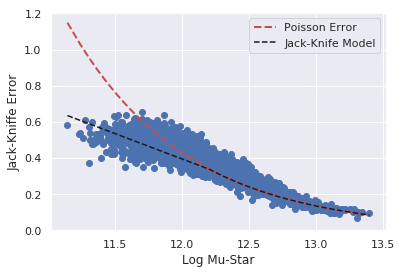

In [12]:
ix = np.argsort(mu_fake)
plt.scatter(mu_fake[ix], jkME[ix])
plt.plot(mu_fake[ix], sigma_yerr(mu_fake[ix]),'r--',lw=2,label='Poisson Error')
plt.plot(mu_fake[ix], jk_error_model(mu_fake[ix]),'k--', label='Jack-Knife Model')
plt.ylabel('Jack-Kniffe Error')
plt.legend()
plt.xlabel('Log Mu-Star')

In [13]:
true = {'alpha':alpha, 'beta': slope, 'Int. Scatter':intScatter}

In [14]:
np.random.seed(42)
var_y = 0.15 # np.std(mu_fake)**2

def get_error(err_type, mean_error, slope=slope, err_std=0.1):
    if err_type=='JK':
        error = jk_error_model(mu_fake, mean=mean_error)
    else:
        error = mean_error
    return error*(1 + err_std*np.random.normal(size=mu_fake.size))

def get_pars(lm):
    aalpha = lm.chain[:]['alpha']
    bbeta = lm.chain[:]['beta']
    sscater = np.sqrt(lm.chain[:]['sigsqr'])
    mean = [np.median(aalpha), np.median(bbeta), np.median(sscater)]
    errors = [np.std(aalpha), np.std(bbeta), np.std(sscater)]
    return mean, errors

def validate_model(Ry, err_type='JK', slope=-0.28, ):
    mean_error = np.sqrt(Ry*var_y)
    error = get_error(err_type, mean_error, slope=slope)
    y, yerr = mu_fake+np.random.normal(scale=error, size=error.size), error
    print('Checking Error: %.3f'%(np.std(mu_fake-y)))
    lm = linmix.LinMix(xn, y, ysig=yerr, K=3, nchains=12)
    lm.run_mcmc(silent=True, maxiter=100000)
    outMean, outError = get_pars(lm)
    return outMean, outError

## Doing Mass Bins Calculations

Since our main issue is with the low mass end. For instance, I'll just do computations for a lower mass thrshold.

In [15]:
def make_muStar_m200_relation(slope, alpha=13.5, intScatter = 0.2):
    return alpha + slope*xn + np.random.normal(scale=intScatter,size=len(xn))
    
def validate_model_mass_bin(mlow, mhig, Npoints=None, Ry=0.9, err_type='JK', err_slope=-0.28):
    mean_error = np.sqrt(Ry*var_y)
    error      = get_error(err_type, mean_error, slope=err_slope)
    muF        = make_muStar_m200_relation(slope, alpha=13.5, intScatter = 0.2)
    y, yerr    = mu_fake+np.random.normal(scale=error, size=error.size), error
    
    # apply mass threshold
    idx = np.where( (x>= mlow) & (x < mhig) & (y>11.) )[0]
    
    if Npoints is not None:
        idx = idx[np.random.randint(0, high=idx.size, size=Npoints)]
    
    print('Checking Error: %.3f'%(np.std(mu_fake-y)))
    
    lm = linmix.LinMix(xn[idx], y[idx], ysig=yerr[idx], K=3, nchains=12)
    lm.run_mcmc(silent=True, maxiter=100000)
    outMean, outError = get_pars(lm)
    return outMean, outError

In [16]:
mbins = np.array([13.5, 13.93, 14.3, 15.])
m3 = (mbins[1:]+mbins[:-1])/2.

In [17]:
results_mass = []
results_massErr = []

print('Running for Ry = %.2f; mean yerr = %.3f'%(0.9, np.sqrt(0.9*var_y)))
for mlo, mhi in zip(mbins[:-1],mbins[1:]):
    print('%.2f < log M < %.2f'%(mlo, mhi))
    means, errors = validate_model_mass_bin(mlo, mhi, err_type='JK')
    results_mass.append(means)
    results_massErr.append(errors)

Running for Ry = 0.90; mean yerr = 0.367
13.50 < log M < 13.93
Checking Error: 0.384
13.93 < log M < 14.30
Checking Error: 0.369
14.30 < log M < 15.00
Checking Error: 0.371


In [18]:
trueVals = np.array(true.values())
frac_bias_mass = ((np.array(results_mass)-trueVals)/trueVals).T
results_massErr = (np.array(results_massErr).T/trueVals[:,np.newaxis])

Text(0,0.5,'Frac. Bias')

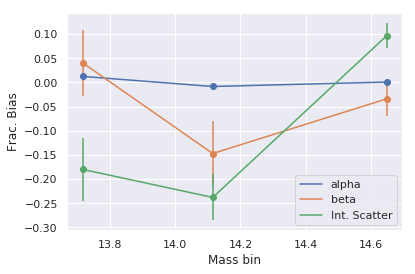

In [19]:
labels = list(true.keys())
for i in range(3):
    p = plt.plot(m3, frac_bias_mass[i], label=labels[i])
    plt.errorbar(m3, frac_bias_mass[i], color=p[0].get_color(), yerr=results_massErr[i]/2., fmt='o', ls=None)

plt.legend()
plt.xlabel('Mass bin')
plt.ylabel('Frac. Bias')

In [20]:
idx = np.where( (x>= 13.5) & (x < 13.93) )[0]
idx.size

1047

In [178]:
## Further investigating the lower mass bin
mlo, mhi = mbins[0], mbins[1]
Npoints = 250

results_massLow = []
results_massLowErr = []

print('Running for Ry = %.2f; mean yerr = %.3f'%(0.9, np.sqrt(0.9*var_y)))
print('%.2f < log M < %.2f'%(mlo, mhi))
for i in range(100):
    print('Realization %i'%i)
    means, errors = validate_model_mass_bin(mlo, mhi, err_type='JK', Npoints=Npoints)
    results_massLow.append(means)
    results_massLowErr.append(errors)

Running for Ry = 0.90; mean yerr = 0.367
13.50 < log M < 13.93
Realization 0
Checking Error: 0.380
Realization 1
Checking Error: 0.368
Realization 2
Checking Error: 0.377
Realization 3
Checking Error: 0.373
Realization 4
Checking Error: 0.370
Realization 5
Checking Error: 0.376
Realization 6
Checking Error: 0.379
Realization 7
Checking Error: 0.371
Realization 8
Checking Error: 0.378
Realization 9
Checking Error: 0.358
Realization 10
Checking Error: 0.370
Realization 11
Checking Error: 0.374
Realization 12
Checking Error: 0.374
Realization 13
Checking Error: 0.376
Realization 14
Checking Error: 0.377
Realization 15
Checking Error: 0.373
Realization 16
Checking Error: 0.376
Realization 17
Checking Error: 0.378
Realization 18
Checking Error: 0.387
Realization 19
Checking Error: 0.372
Realization 20
Checking Error: 0.370
Realization 21
Checking Error: 0.370
Realization 22
Checking Error: 0.379
Realization 23
Checking Error: 0.362
Realization 24
Checking Error: 0.368
Realization 25
Checkin

In [179]:
trueVals = np.array(true.values())
frac_bias_massLow = ((np.array(results_massLow)-trueVals)/trueVals).T
results_massLowErr = (np.array(results_massLowErr).T/trueVals[:,np.newaxis])

Text(0.5,1,'Low Mass Bin, Npoints=250, Slope=0.9, intScatter=0.2')

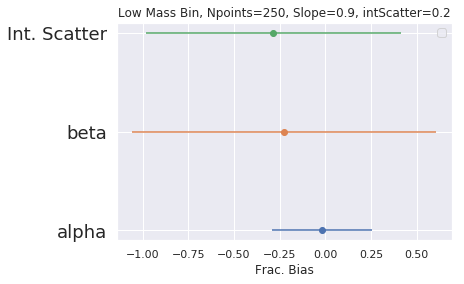

In [215]:
fig, ax = plt.subplots()

labels = list(true.keys())
for i in range(3):
    mean, err0, err1 = np.mean(frac_bias_massLow[i]), np.std(frac_bias_massLow[i]), np.mean(results_massLowErr[i])
    err = np.sqrt(err0*2 + err1**2)
    ax.errorbar(mean, i,  xerr=err, fmt='o', ls=None)

ax.set_yticks(range(3))
ax.set_yticklabels(labels, fontsize=18)
ax.legend()
ax.set_xlabel('Frac. Bias')

ax.set_title('Low Mass Bin, Npoints=250, Slope=0.9, intScatter=0.2')

## Solution: Censoring

In [21]:
def make_muStar_m200_relation(slope, alpha=13.5, intScatter = 0.2):
    return alpha + slope*xn + np.random.normal(scale=intScatter,size=len(xn))
    
def validate_model_mass_bin_cens(mlow, mhig, Npoints=None, Ry=0.9, err_type='JK', err_slope=-0.28):
    mean_error = np.sqrt(Ry*var_y)
    error      = get_error(err_type, mean_error, slope=err_slope)
    y, yerr    = mu_fake+np.random.normal(scale=error, size=error.size), error
    
    # apply mass threshold
    idx = np.where( (x>= mlow) & (x < mhig))[0]
    
    if Npoints is not None:
        idx = idx[np.random.randint(0, high=idx.size, size=Npoints)]

    # apply mu-star threshold
    delta =  y[idx] > 11.
    print('Np: %i'%np.count_nonzero(delta))
    ycens = np.where(y[idx]<11., 11., y[idx])
    
    lm = linmix.LinMix(xn[idx], ycens, ysig=yerr[idx], delta=delta, K=2, nchains=12)
    lm.run_mcmc(silent=True, maxiter=100000)
    outMean, outError = get_pars(lm)
    return outMean, outError

In [22]:
results_mass = []
results_massErr = []

print('Running for Ry = %.2f; mean yerr = %.3f'%(0.9, np.sqrt(0.9*var_y)))
for mlo, mhi in zip(mbins[:-1],mbins[1:]):
    print('%.2f < log M < %.2f'%(mlo, mhi))
    means, errors = validate_model_mass_bin_cens(mlo, mhi, err_type='JK')
    results_mass.append(means)
    results_massErr.append(errors)

Running for Ry = 0.90; mean yerr = 0.367
13.50 < log M < 13.93
Np: 984
13.93 < log M < 14.30
Np: 803
14.30 < log M < 15.00
Np: 844


In [23]:
trueVals = np.array(true.values())
frac_bias_mass = ((np.array(results_mass)-trueVals)/trueVals).T
results_massErr = (np.array(results_massErr).T/trueVals[:,np.newaxis])

Text(0,0.5,'Frac. Bias')

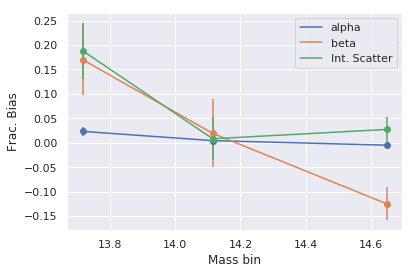

In [24]:
labels = list(true.keys())
for i in range(3):
    p = plt.plot(m3, frac_bias_mass[i], label=labels[i])
    plt.errorbar(m3, frac_bias_mass[i], color=p[0].get_color(), yerr=results_massErr[i]/2., fmt='o', ls=None)

plt.legend()
plt.xlabel('Mass bin')
plt.ylabel('Frac. Bias')

In [35]:
## Further investigating the lower mass bin
mlo, mhi = mbins[0], mbins[1]
Npoints = 250

results_massLow = []
results_massLowErr = []

print('Running for Ry = %.2f; mean yerr = %.3f'%(0.9, np.sqrt(0.9*var_y)))
print('%.2f < log M < %.2f'%(mlo, mhi))
for i in range(100):
    print('Realization %i'%i)
    means, errors = validate_model_mass_bin_cens(mlo, mhi, err_type='JK', Npoints=Npoints)
    print(means)
    print('')
    results_massLow.append(means)
    results_massLowErr.append(errors)

Running for Ry = 0.90; mean yerr = 0.367
13.50 < log M < 13.93
Realization 0
Np: 238
[13.657804459904781, 0.9829500752818404, 0.20730893358529093]

Realization 1
Np: 239
[13.542648072863136, 0.9058372684909077, 0.21402771471914794]

Realization 2
Np: 228
[13.811688416451947, 1.0722580874173482, 0.2911180496153164]

Realization 3
Np: 238
[12.939266566500935, 0.5534731581514969, 0.20497193765960148]

Realization 4
Np: 236
[12.507661426745539, 0.3390783106650894, 0.24379463508161836]

Realization 5
Np: 231
[13.830046403352211, 1.0606820968196415, 0.2895475114026135]

Realization 6
Np: 234
[13.288169026273163, 0.7475867863355106, 0.29871026342153]

Realization 7
Np: 240
[14.00850572242188, 1.1584888692516409, 0.20645448674799236]

Realization 8
Np: 240
[13.63882245666861, 0.9647386014576639, 0.07860239293089351]

Realization 9
Np: 238
[13.393700845645522, 0.8043615867556597, 0.2131469281967741]

Realization 10
Np: 233
[14.028415389327096, 1.1759092956111585, 0.22456284340248656]

Realizati

[13.94635357358706, 1.1174480696139848, 0.19282292000523654]

Realization 97
Np: 238
[12.885692279972671, 0.5191232922052094, 0.2583691850686274]

Realization 98
Np: 235
[13.903647807481157, 1.1177648882539404, 0.1823581567027266]

Realization 99
Np: 239
[12.69032095534654, 0.4244062625813894, 0.1480679460400683]



In [36]:
trueVals = np.array(true.values())
frac_bias_massLow = ((np.array(results_massLow)-trueVals)/trueVals).T
results_massLowErr = (np.array(results_massLowErr).T/trueVals[:,np.newaxis])

Text(0.5,1,'Low Mass Bin, Npoints=250, Slope=0.9, intScatter=0.2 \n Censored Data')

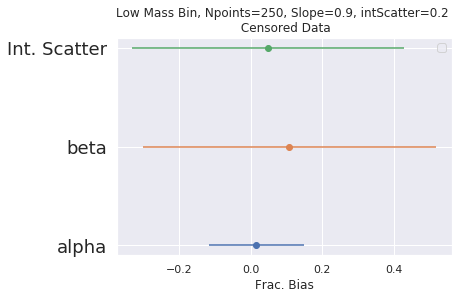

In [42]:
fig, ax = plt.subplots()

labels = list(true.keys())
for i in range(3):
    mean, err0, err1 = np.mean(frac_bias_massLow[i]), np.std(frac_bias_massLow[i]), np.mean(results_massLowErr[i])
    err = np.sqrt(err0*2 + err1**2)
    ax.errorbar(mean, i,  xerr=err/2., fmt='o', ls=None)

ax.set_yticks(range(3))
ax.set_yticklabels(labels, fontsize=18)
ax.legend()
ax.set_xlabel('Frac. Bias')

ax.set_title('Low Mass Bin, Npoints=250, Slope=0.9, intScatter=0.2 \n Censored Data')

In [33]:
# help(np.random.randint)

## Real Data: Bootstrap

In [17]:
import sys
sys.path.append('/home/s1/jesteves/git/buzzardAnalysis/mainAnalysis/selectionEffect/')

from fit_mor_evolution import mass_observable_relation, load_mor_results, save_mor_results, get_output_variables

In [18]:
mor_evol = load_mor_results('mor_uniform_matrix')

zbins = np.linspace(0.1,0.65,4)
zmed = 0.5*(zbins[1:]+zbins[:-1])

In [19]:
import sys
sys.path.append("/home/s1/jesteves/git/ccopa/python/")
from main import copacabana

run = 'gauss003_rhod_02Lstar_raper100'
root = '/home/s1/jesteves/git/buzzardAnalysis/mainAnalysis/'
cfg = root+'config_buzzard_v2.yaml'
copa = copacabana(cfg,dataset='buzzard_v2')
cat = copa.load_copa_out('cluster',run)


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


master file: 
 /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00000.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00016.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00017.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00018.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00019.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00020.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00022.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00032.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00033.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00034.hdf5
/data/des61.a/data/johnny

In [20]:
## Pivot points
Mp = 10.**15.5
Mup= 1./10**10

zcls = np.array(cat['redshift'])
m200 = np.log10(np.array(cat['M200_true']/Mp))

# lbd = np.array(cat['LAMBDA_CHISQ'].astype(float))
# log_lbd = np.log10(lbd)
# lbd_e = np.array(cat['LAMBDA_CHISQ_E'].astype(float))
# log_lbd_e = lbd_e/lbd

mu = np.array(cat['MU']/Mup)
mu_e = np.array(cat['MU_ERR_JK']/Mup)
log_mu = np.log10(mu)
log_mu_e = mu_e/mu

In [21]:
mask = (mu>1.)
zkeys = [np.where((zcls>=xmin)&(zcls<=xmax)&mask)[0] for xmin, xmax 
            in zip(zbins[:-1],zbins[1:])]
def re_size(x,Mp=10.**15.5):
    return np.log10(Mp*10**x*0.7)


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [49]:
nBootStrap = 100
muSigma = np.zeros((3,3),dtype=float)
muSigmaErr = np.zeros((3,3),dtype=float)

In [50]:
print('Run: %s \n'%run)
print(5*'----')
mylistMu = []
for ixz in range(3):
    name = run+'_z%i'%ixz
    zlabel = '%.2f < z < %.2f'%(zbins[ixz],zbins[ixz+1])
    print(zlabel)
    output = np.zeros((nBootStrap,3,2),dtype=float)
    
    #x, y, y_err, delta = self.get_variable(name,is_log=True)
    x, y, y_err = m200[zkeys[ixz]], log_mu[zkeys[ixz]], log_mu_e[zkeys[ixz]]
    xn = np.log10(10**x/Mp)
    bins = [np.where((re_size(x)>=xmin)&(re_size(x)<xmax)&(y>11.))[0] for xmin, xmax 
            in zip(mbins[:-1],mbins[1:])]
    
    out, out2 = [], []
    for ixm, idx0 in enumerate(bins):
        print('Mass Bin: %.2f < log(M) < %.2f'%(mbins[ixm],mbins[ixm+1]) )
        print('Number of points: %i'%(len(idx0)))
        for i in range(nBootStrap):
            idx = idx0[np.random.randint(0,len(idx0),size=len(idx0))]
            delta =  y[idx] > 11.
            ycens = np.where(y[idx]<11., 11., y[idx])
            lm = linmix.LinMix(xn[idx], ycens, ysig=y_err[idx], delta=delta, K=3, nchains=12)
            lm.run_mcmc(silent=True, maxiter=100000)
            smean, serr = np.median(np.sqrt(lm.chain[:]['sigsqr'])), np.std(np.sqrt(lm.chain[:]['sigsqr']))
            slope = np.median(lm.chain[:]['beta'])
            
            print('slope, scatter: %.3f, %.3f'%(slope,smean))
            #print('Number of Outliers %i'%(np.count_nonzero(mask)))
            output[i, ixm, 0] = smean
            output[i, ixm, 1] = slope
            out.append(smean)
            out2.append(serr)
            
        muSigma[ixm,ixz] = np.nanmean(out)
        muSigmaErr[ixm,ixz] = np.sqrt(np.nanstd(out)**2+np.nanmean(out2)**2)
    #dataD[name] = out
    #muLm.append(out)
    mylistMu.append(output)
    print('')
x = re_size(x)

Run: gauss003_rhod_02Lstar_raper100 

--------------------
0.10 < z < 0.28
Mass Bin: 13.50 < log(M) < 13.93
Number of points: 269
slope, scatter: 0.706, 0.285
slope, scatter: 0.588, 0.208
slope, scatter: 0.874, 0.216
slope, scatter: 0.838, 0.101
slope, scatter: 0.755, 0.207
slope, scatter: 0.567, 0.192
slope, scatter: 0.781, 0.188
slope, scatter: 0.816, 0.199
slope, scatter: 1.113, 0.170
slope, scatter: 0.532, 0.162
Mass Bin: 13.93 < log(M) < 14.30
Number of points: 244
slope, scatter: 1.002, 0.095
slope, scatter: 0.933, 0.130
slope, scatter: 1.001, 0.073
slope, scatter: 0.897, 0.165
slope, scatter: 0.991, 0.142
slope, scatter: 1.287, 0.126
slope, scatter: 0.934, 0.105
slope, scatter: 0.890, 0.115
slope, scatter: 0.730, 0.152
slope, scatter: 0.833, 0.134
Mass Bin: 14.30 < log(M) < 15.00
Number of points: 215
slope, scatter: 0.818, 0.088
slope, scatter: 0.939, 0.113
slope, scatter: 0.944, 0.129
slope, scatter: 0.748, 0.097
slope, scatter: 0.876, 0.102
slope, scatter: 0.990, 0.114
slope,

In [73]:
muSigma_fixed_obs = np.zeros((3,3),dtype=float)
muSigmaErr_fixed_obs = np.zeros((3,3),dtype=float)

for ixz in range(3):
    output = mylistMu[ixz]
    print('z bin: %i'%ixz)
    for ixm in range(3):
        muSigma_fixed_obs[ixm, ixz] = np.median(output[:,ixm,0]/output[:,ixm,1])
        muSigmaErr_fixed_obs[ixm, ixz] = np.std(output[:,ixm,0]/output[:,ixm,1])
        print('slope, sigma, sigma_obs: %.3f, %.3f, %.3f'%
              (np.mean(output[:,ixm,1]),np.mean(output[:,ixm,0]),muSigma_fixed_obs[ixm, ixz]))

z bin: 0
slope, sigma, sigma_obs: 0.757, 0.193, 0.261
slope, sigma, sigma_obs: 0.950, 0.124, 0.134
slope, sigma, sigma_obs: 0.883, 0.115, 0.129
z bin: 1
slope, sigma, sigma_obs: 0.570, 0.179, 0.287
slope, sigma, sigma_obs: 0.882, 0.157, 0.171
slope, sigma, sigma_obs: 1.238, 0.159, 0.130
z bin: 2
slope, sigma, sigma_obs: 0.229, 0.131, 0.579
slope, sigma, sigma_obs: 0.675, 0.158, 0.234
slope, sigma, sigma_obs: 1.004, 0.232, 0.242


In [74]:
np.save('muSigma2', muSigma_fixed_obs)
np.save('muSigmaErr2', muSigmaErr_fixed_obs)
np.save('muSigma',muSigma)
np.save('muSigmaErr',muSigmaErr)

In [75]:
import os
if os.path.isfile('muSigma.npy'):
    muSigma = np.load('muSigma.npy')
    muSigmaErr = np.load('muSigmaErr.npy')
    muSigma_fixed_obs = np.load('muSigma2.npy')
    muSigmaErr_fixed_obs = np.load('muSigmaErr2.npy')

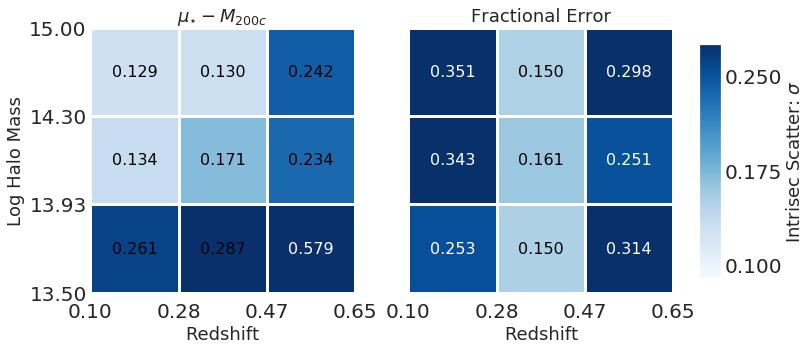

In [66]:
fig, axs = plt.subplots(1, 2,figsize=(12,5))

v0, v1 = 0.1, 0.25
ax = axs[0]
im = heatmap(muSigma_fixed_obs,  mlabels, zlabels, ax=ax, origin='lower',
                   cmap="Blues", cbarlabel=r"$\sigma$", vmin=v0*0.9, vmax=v1*1.1)

texts = annotate_heatmap(im, valfmt="{x:.3f}")
ax.set_ylabel('Log Halo Mass', fontsize=18)
ax.set_xlabel('Redshift', fontsize=18)
ax.set_title(r'$\mu_{\star}-M_{200c}$',fontsize=18)

ax = axs[1]
im = heatmap(muSigmaErr/muSigma, '', zlabels, ax=ax, origin='lower',cmap="Blues", vmin=v0*0.9, vmax=v1*1.1)

texts = annotate_heatmap(im, valfmt="{x:.3f}")
# ax.set_ylabel('Log Halo Mass', fontsize=18)
ax.set_xlabel('Redshift', fontsize=18)
# ax.set_title(r'$\lambda-M_{200c}$',fontsize=18)
ax.set_title(r'Fractional Error',fontsize=18)
# fig.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.175, 0.025, 0.65])
cbar = fig.colorbar(im, cax=cbar_ax,  ticks=np.linspace(v0,v1,3)).set_label(r'Intrisec Scatter: $\sigma$',fontsize=18)
# cbar.ax.set_yticklabels(np.arange(0.1, 0.4, 0.1))

# save_figures(fig,5,is_tight=False, ext='png')

In [30]:
mlabels = ["%.2f"%(mi) for mi in mbins]
zlabels = ["%.2f"%(mi) for mi in zbins]

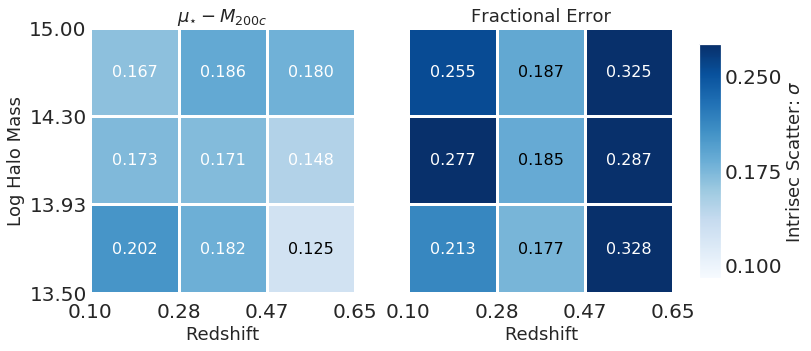

In [31]:
fig, axs = plt.subplots(1, 2,figsize=(12,5))

v0, v1 = 0.1, 0.25
ax = axs[0]
im = heatmap(muSigma,  mlabels, zlabels, ax=ax, origin='lower',
                   cmap="Blues", cbarlabel=r"$\sigma$", vmin=v0*0.9, vmax=v1*1.1)

texts = annotate_heatmap(im, valfmt="{x:.3f}")
ax.set_ylabel('Log Halo Mass', fontsize=18)
ax.set_xlabel('Redshift', fontsize=18)
ax.set_title(r'$\mu_{\star}-M_{200c}$',fontsize=18)

ax = axs[1]
im = heatmap(muSigmaErr/muSigma, '', zlabels, ax=ax, origin='lower',cmap="Blues", vmin=v0*0.9, vmax=v1*1.1)

texts = annotate_heatmap(im, valfmt="{x:.3f}")
# ax.set_ylabel('Log Halo Mass', fontsize=18)
ax.set_xlabel('Redshift', fontsize=18)
# ax.set_title(r'$\lambda-M_{200c}$',fontsize=18)
ax.set_title(r'Fractional Error',fontsize=18)
# fig.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.175, 0.025, 0.65])
cbar = fig.colorbar(im, cax=cbar_ax,  ticks=np.linspace(v0,v1,3)).set_label(r'Intrisec Scatter: $\sigma$',fontsize=18)
# cbar.ax.set_yticklabels(np.arange(0.1, 0.4, 0.1))

# save_figures(fig,5,is_tight=False, ext='png')

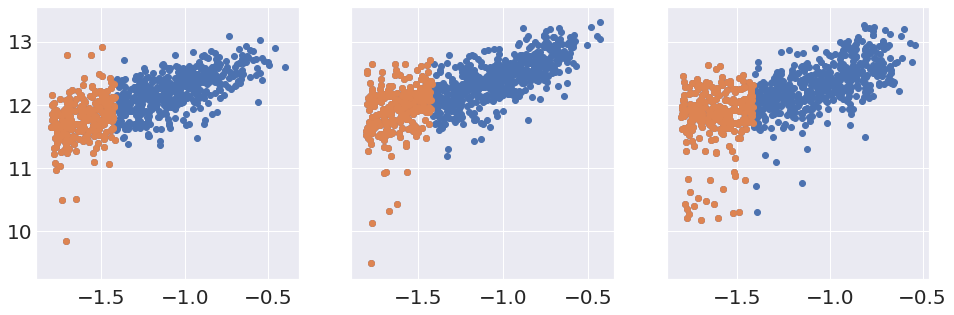

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(16,5), sharey='all')

for ixz in range(3):
    x = m200[zkeys[ixz]]
    bins = [np.where((re_size(x)>=xmin)&(re_size(x)<xmax))[0] for xmin, xmax 
            in zip(mbins[:-1],mbins[1:])]

    axs[ixz].scatter(x, log_mu[zkeys[ixz]])
    axs[ixz].scatter(x[bins[0]], log_mu[zkeys[ixz]][bins[0]])


In [ ]:
x = m200[zkeys[ixz]]
y = log_mu[zkeys[ixz]]

delta =  y > 11.
ycens = np.where(y<11., 11., y)
lm = linmix.LinMix(xn, ycens, ysig=y_err[idx], delta=delta, K=3, nchains=12)
lm.run_mcmc(silent=True, maxiter=100000)


### Fixed Slope Varying The Y-Error

In [18]:
Ry = [0.1, 0.5, 0.7, 1.0, 1.5, 2.0, 3., 5., 7., 10.]

results = []
resultsErr = []
for ryi in Ry:
    print('Running for Ry = %.2f; mean yerr = %.3f'%(ryi, np.sqrt(ryi*var_y)))
    mean, errors = validate_model(ryi, err_type='JK')
    results.append(mean)
    resultsErr.append(errors)

Running for Ry = 0.10; mean yerr = 0.122
Checking Error: 0.160
Running for Ry = 0.50; mean yerr = 0.274
Checking Error: 0.293
Running for Ry = 0.70; mean yerr = 0.324
Checking Error: 0.336
Running for Ry = 1.00; mean yerr = 0.387
Checking Error: 0.378
Running for Ry = 1.50; mean yerr = 0.474
Checking Error: 0.456
Running for Ry = 2.00; mean yerr = 0.548
Checking Error: 0.524
Running for Ry = 3.00; mean yerr = 0.671
Checking Error: 0.627
Running for Ry = 5.00; mean yerr = 0.866
Checking Error: 0.819
Running for Ry = 7.00; mean yerr = 1.025
Checking Error: 0.954
Running for Ry = 10.00; mean yerr = 1.225
Checking Error: 1.132


In [19]:
trueVals = np.array(true.values())
frac_bias = ((np.array(results)-trueVals)/trueVals).T
resultsErr = (np.array(resultsErr).T/trueVals[:,np.newaxis])

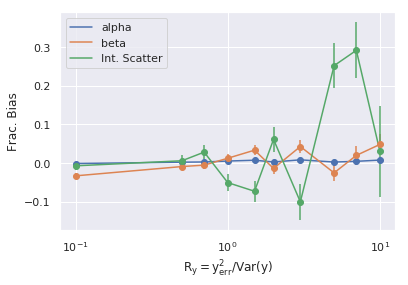

In [20]:
labels = list(true.keys())
for i in range(3):
    p = plt.plot(Ry, frac_bias[i], label=labels[i])
    plt.errorbar(Ry, frac_bias[i], yerr=resultsErr[i]/2., fmt='o', ls=None, color=p[0].get_color())
plt.legend()
plt.xlabel(r'$\rm R_y = y^2_{err}/Var(y)$')
plt.ylabel('Frac. Bias')
plt.xscale('log')

Takeaways for a fixed slope at 0.9:
<li> $R_y<1$: when the error on y are lower than its variance, the fractional error on the fitted parameters is below 5%.
<li> $R_y>1$: the fractional error on the fitted parameters is more than 10%, especially for intrisec scater.
    
<b> The uncertainty on the int. scatter is very high on the cases of errors much greater than the variance.

In [21]:
Ry_real = np.mean(jkME)**2/var_y
print('The value of Ry for the real data is about:')
print('Ry: %.3f'%Ry_real)


The value of Ry for the real data is about:
Ry: 0.873


### Fixed Y-Error Varying Slope; Ry = 0.9

In [103]:
def make_muStar_m200_relation(slope, alpha=13.5, intScatter = 0.2):
    return alpha + slope*xn + np.random.normal(scale=intScatter,size=len(xn))
    
def validate_model_slope(slope, Ry=0.9, err_type='JK', err_slope=-0.28):
    mean_error = np.sqrt(Ry*var_y)
    error      = get_error(err_type, mean_error, slope=err_slope)
    muF        = make_muStar_m200_relation(slope, alpha=13.5, intScatter = 0.2)
    y, yerr    = muF+np.random.normal(scale=error, size=error.size), error
    print('Checking Error: %.3f'%(np.std(muF-y)))
    lm = linmix.LinMix(xn, y, ysig=yerr, K=3, nchains=12)
    lm.run_mcmc(silent=True, maxiter=100000)
    outMean, outError = get_pars(lm)
    return outMean, outError

In [68]:
slopes = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]

In [69]:
results_slope = []
results_slopeErr = []
trueVals = []

print('Running for Ry = %.2f; mean yerr = %.3f'%(0.9, np.sqrt(0.9*var_y)))
for slope in slopes:
    print('Slope: %.2f'%slope)
    means, errors = validate_model_slope(slope, err_type='JK')
    trueVals.append([alpha, slope, intScatter])
    results_slope.append(means)
    results_slopeErr.append(errors)

Running for Ry = 0.90; mean yerr = 0.367
Slope: 0.10
Checking Error: 0.364
Slope: 0.20
Checking Error: 0.366
Slope: 0.40
Checking Error: 0.376
Slope: 0.60
Checking Error: 0.369
Slope: 0.80
Checking Error: 0.367
Slope: 1.00
Checking Error: 0.376


In [71]:
trueVals = np.array(trueVals)
frac_bias_slope = ((np.array(results_slope)-trueVals)/trueVals).T
results_slopeErr = (np.array(results_slopeErr)/trueVals).T

Text(0,0.5,'Frac. Bias')

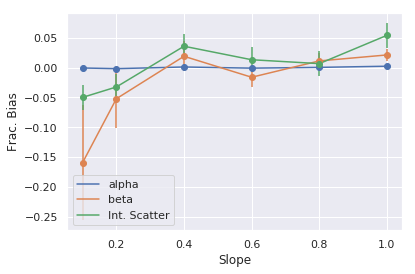

In [100]:
labels = list(true.keys())
for i in range(3):
    p = plt.plot(slopes, frac_bias_slope[i], label=labels[i])
    plt.errorbar(slopes, frac_bias_slope[i], color=p[0].get_color(), yerr=results_slopeErr[i]/2., fmt='o', ls=None)

plt.legend()
plt.xlabel('Slope')
plt.ylabel('Frac. Bias')

Varying the slope doesn't seems to affect the precision of the fitted parameters. Roughly we can say linmix predicts the scatter with a 5% level.

### Further Testing at Slope=0.2; Make 20 Realizations

In [104]:
slope=0.2
out = []
outErr = []
for i in range(20):
    mean, errors = validate_model_slope(slope, err_type='JK')
    out.append(mean)
    outErr.append(errors)

Checking Error: 0.368
Checking Error: 0.374
Checking Error: 0.379
Checking Error: 0.378
Checking Error: 0.379
Checking Error: 0.370
Checking Error: 0.378
Checking Error: 0.367
Checking Error: 0.371
Checking Error: 0.361
Checking Error: 0.370
Checking Error: 0.371
Checking Error: 0.383
Checking Error: 0.381
Checking Error: 0.375
Checking Error: 0.379
Checking Error: 0.380
Checking Error: 0.368
Checking Error: 0.371
Checking Error: 0.372


In [121]:
slope02 = ((np.array(out)-trueVals[1])/trueVals[1]).T

(array([1., 0., 0., 3., 2., 3., 4., 1., 5., 1.]),
 array([-19.33199011, -15.77954773, -12.22710535,  -8.67466297,
         -5.12222059,  -1.56977821,   1.98266417,   5.53510655,
          9.08754893,  12.63999132,  16.1924337 ]),
 <a list of 10 Patch objects>)

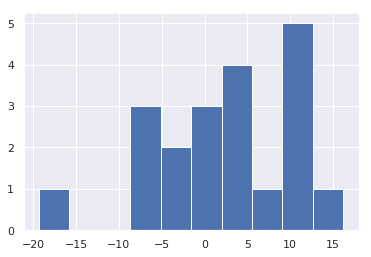

In [132]:
plt.hist(slope02[1]*100)

In [135]:
np.mean(slope02[1])*100, np.std(slope02[1])*100

(2.322366380956717, 8.050703063242324)

After doing 20 measurements at the same slope (0.2) we can interpret the above numbers as rough estimations of the precision of this measurements. It's about 5%. 

# Previous Stuff

In [11]:
sError = 0.37

In [12]:
yD = {}
yD['True'] = [mu_fake, np.zeros_like(mu_fake)]
yD['JK']   = [mu_fake+np.random.normal(scale=jkME, size=jkME.size),jkME]
yD['Gaus'] = [mu_fake+np.random.normal(scale=sError, size=len(mu_fake)), sError*np.ones_like(mu_fake)]

Text(0.5,1,'Log Mu-Star')

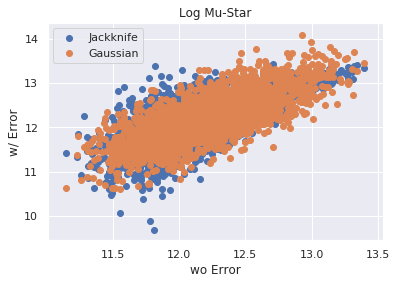

In [13]:
plt.scatter(mu_fake, yD['JK'][0], label='Jackknife')
plt.scatter(mu_fake, yD['Gaus'][0], label='Gaussian')
plt.xlabel('wo Error')
plt.ylabel('w/ Error')
plt.legend()
plt.title('Log Mu-Star')

Text(0.5,0,'Log Mu Star')

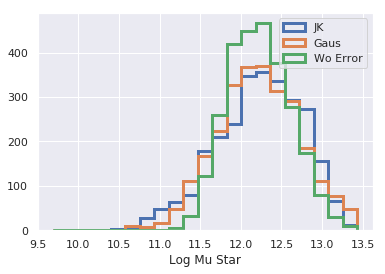

In [14]:
_ = plt.hist(yD['JK'][0], bins=21, histtype='step', lw=3, label='JK')
_ = plt.hist(yD['Gaus'][0], bins=_[1], histtype='step', lw=3, label='Gaus')
_ = plt.hist(mu_fake, bins=_[1], histtype='step', lw=3, label='Wo Error')
plt.legend()
plt.xlabel('Log Mu Star')

## Testing Linmix

In [15]:
# np.corrcoef(mu_fake,x)

In [16]:
true = {'alpha':alpha, 'beta': slope, 'Int. Scatter':intScatter}

In [17]:
from collections import defaultdict
data = defaultdict()

In [18]:
# plot_validation
def get_posterior(data, name, err_type):
    lm = data[name][err_type]    
    aalpha = lm.chain[:]['alpha']
    bbeta = lm.chain[:]['beta']
    sscater = np.sqrt(lm.chain[:]['sigsqr'])
    #ccor = np.sqrt(lm.chain[:]['corr'])
    return aalpha, bbeta, sscater

def get_title(pos):
    xmean, xsig = np.median(pos), np.std(pos)
    return r'$%.3f \pm %.3f$'%(xmean, xsig)

def plot_validation(data, name, err_type):
    labels = true.keys()
    out = get_posterior(data, name, err_type)
    fig, axs = plt.subplots(1,3,figsize=(12,4),sharey=True)
    fig.subplots_adjust(wspace=0.01)

    for i,pi in enumerate(out):
        axs[i].hist(pi,bins=21)
        axs[i].axvline(np.median(pi),ls='--',lw=3,color='w')
        axs[i].set_title(get_title(pi))
        axs[i].axvline(true[labels[i]],ls='--',lw=3,color='r')
        axs[i].set_xlabel(labels[i])
        
    fig.suptitle(err_type)

## Covariate Error

The linear equation is:
$$
y = \alpha+\beta x +\epsilon_i
$$

In the case the error is correlated with x, the slope is affected. For instance, assume that the error is of the form $u_i = \beta_2 x + \epsilon_i$, we have then:
$$
y = \alpha+\beta x +u_i\\
y = \alpha+\beta x + (\beta_2 x +\epsilon_i)\\ 
y = \alpha+(\beta + \beta_2 )x +\epsilon_i
$$

In our case, the correlated error is on the y-variable. But the results on the slope is still the same, since by the definiton of the package, $y_{err}$, is positive if we pass to the right hand side of the equation.

### Covariate Error

To illustrate the issue, we fit the $\mu_{star}-M_{200c}$ relation for uncorrelated gaussian error and for a jackknife error which is correlated with the x variable. The result is a steeper slope.

In [19]:
name = 'CovError'

In [24]:
out = {}
for tag, [y, yerr] in zip(yD.keys(),yD.values()):
    print('Error Type: %s'%tag)
    lm = linmix.LinMix(xn, y, ysig=yerr, K=3, nchains=12)
    lm.run_mcmc(silent=True, maxiter=100000)
    out[tag] = lm
    
data[name] = out

Error Type: Gaus
Error Type: True
Error Type: JK


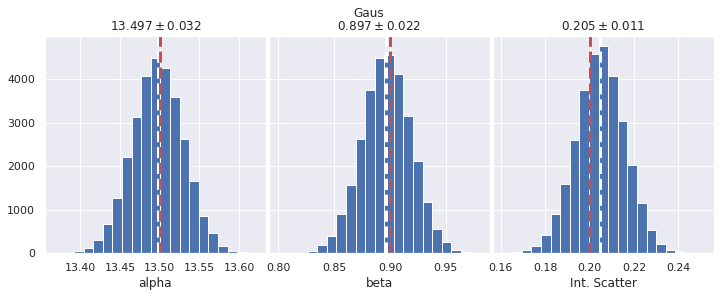

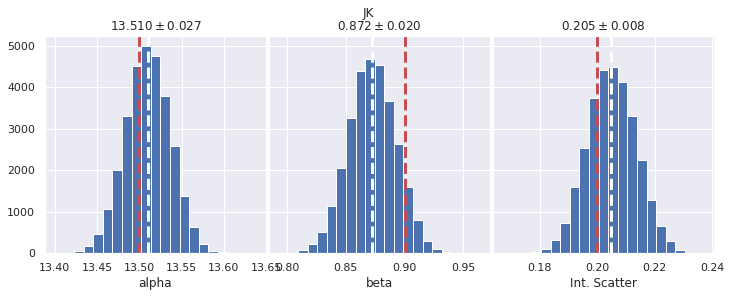

In [25]:
tags = ['Gaus','JK']
for tag in tags:
    plot_validation(data, name, tag)

## Heterostedicity

### Correction on Y

The error is modeled as:

$$
\text{error}(y_i) = A / \sqrt{y_i} + \epsilon(y_i)
$$

So, the correction is:
$$
\text{error}(y_i) \rightarrow \text{error}(y_i) - A / \sqrt{y_i}
$$

We don't know $y_i$ in principle. But I'll assume in first approx. $y_{obs} = y$

In [29]:
y = mu_fake
yerr = yD['JK'][1]

In [30]:
error_i =  yD['JK'][0]-y

In [31]:
def get_variance(x, y, nbins=11):
    xbins = np.percentile(x, np.linspace(0,100,nbins))#np.linspace(np.min(x),np.max(x),nbins)
    xmed = (xbins[1:]+xbins[:-1])/2.
    bins = [np.where((x>=xmin)&(x<xmax))[0] for xmin, xmax 
            in zip(xbins[:-1],xbins[1:])]
    ymean = np.array([np.mean(y[idx]) for idx in bins])
    var = np.array([np.std(y[idx]) for idx in bins])**2
    return xmed, ymean, var

<ErrorbarContainer object of 3 artists>

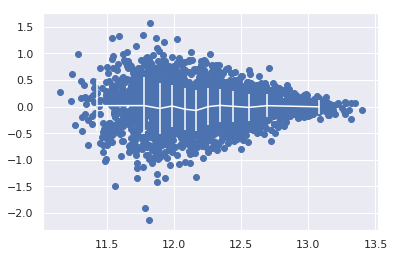

In [32]:
ymed, ymean, var = get_variance(y, error_i, nbins=13)

plt.scatter(y, error_i)
plt.errorbar(ymed, ymean, yerr=np.sqrt(var), color='w')

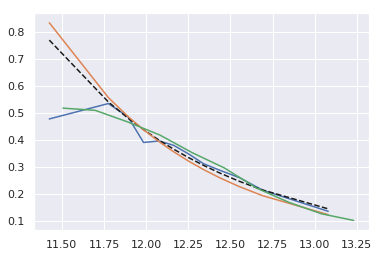

In [94]:
# plt.loglog()
plt.plot(ymed, np.sqrt(var))
plt.plot(ymed, 10**log_var_func(ymed-12.),'k--')
plt.plot(ymed, sigma_yerr(ymed))
plt.plot(np.log10(_jkME[0]), _jkME[1])

In [61]:
yerr = yD['JK'][1]
y = mu_fake+np.random.normal(scale=sError)
lm = linmix.LinMix(y, yerr, K=3, nchains=12)
lm.run_mcmc(silent=True, maxiter=100000)


In [62]:
aa = lm.chain[:]['alpha']
bb = lm.chain[:]['beta']
ss = np.sqrt(lm.chain[:]['sigsqr'])

yvec = np.linspace(np.min(y),np.max(y),100)
# yvec = np.log10(Mp*10**xvecn)

Text(0.5,0,'Log Halo Mass')

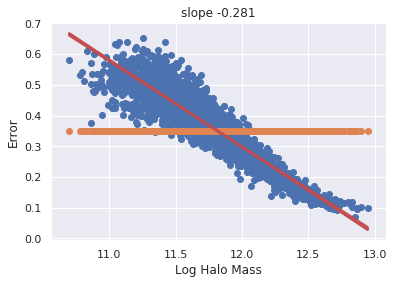

In [63]:
indices = np.random.randint(aa.size, size=100)

plt.scatter(y,yD['JK'][1])
plt.scatter(y,yD['Gaus'][1])

for i in indices:
    plt.plot(yvec, yvec*bb[i]+aa[i], 'r', alpha=0.3)

label = 'slope %.3f'%(np.median(bb))
plt.title(label)
plt.ylabel('Error')
plt.xlabel('Log Halo Mass')

In [81]:
rres = yerr[:,np.newaxis]-(y[:,np.newaxis]*bb+aa)
res = np.median(rres,1)
corr_yerr = res+np.median(yerr)

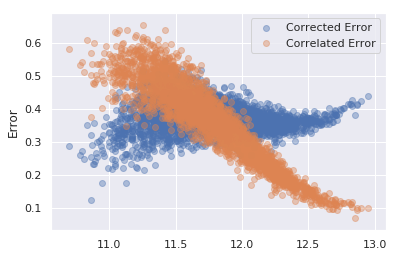

In [82]:
plt.scatter(y,corr_yerr,alpha=0.4,label='Corrected Error')
plt.scatter(y,yerr,alpha=0.4,label='Correlated Error')
plt.ylabel('Error')
plt.legend()

In [83]:
yD['Corrected2'] = [mu_fake+np.random.normal(scale=corr_yerr,size=yerr.size),corr_yerr]

### Correction

In [30]:
yerr = yD['JK'][1]
lm = linmix.LinMix(xn, yerr, K=3, nchains=12)
lm.run_mcmc(silent=True, maxiter=100000)

In [31]:
aa = lm.chain[:]['alpha']
bb = lm.chain[:]['beta']
ss = np.sqrt(lm.chain[:]['sigsqr'])

xvecn = np.linspace(np.min(xn),np.max(xn),100)
xvec = np.log10(Mp*10**xvecn)
# aa, bb, ss = get_posterior(data, name, err_type)

Text(0.5,0,'Log Halo Mass')

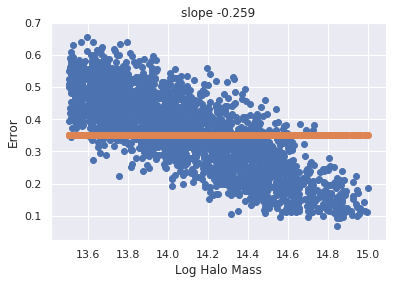

In [32]:
indices = np.random.randint(aa.size, size=100)

plt.scatter(x,yD['JK'][1])
plt.scatter(x,yD['Gaus'][1])

# for i in indices:
#     plt.plot(xvec, xvecn*bb[i]+aa[i], 'r', alpha=0.3)

label = 'slope %.3f'%(np.median(bb))
plt.title(label)
plt.ylabel('Error')
plt.xlabel('Log Halo Mass')

### Should be the error the residual?

In [33]:
rres = yerr[:,np.newaxis]-xn[:,np.newaxis]*bb+aa
res = np.median(rres,1)
corr_yerr = res+np.median(yerr)

In [34]:
corr_yerr = np.random.normal(size=len(yerr), scale=np.median(ss))#+np.median(yerr)

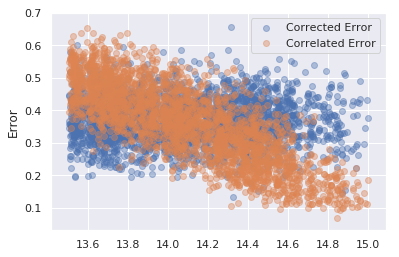

In [35]:
plt.scatter(x,corr_yerr,alpha=0.4,label='Corrected Error')
plt.scatter(x,yerr,alpha=0.4,label='Correlated Error')
plt.ylabel('Error')
plt.legend()

In [36]:
# plt.scatter(y-np.median(y),yerr-np.median(yerr))

In [49]:
yD['Corrected'] = [mu_fake+corr_yerr,corr_yerr+np.median(yerr)]

## Re-Run Linmix

In [91]:
tag = 'Corrected'
out = {}
print('Error Type: %s'%tag)
lm = linmix.LinMix(xn, yD[tag][0], ysig=yD[tag][1], K=3, nchains=12)
lm.run_mcmc(silent=True, maxiter=100000)
data[name][tag] = lm

Error Type: Corrected


In [92]:
tag = 'Corrected2'
out = {}
print('Error Type: %s'%tag)
lm = linmix.LinMix(xn, yD[tag][0], ysig=yD[tag][1], K=3, nchains=12)
lm.run_mcmc(silent=True, maxiter=100000)
data[name][tag] = lm

Error Type: Corrected2


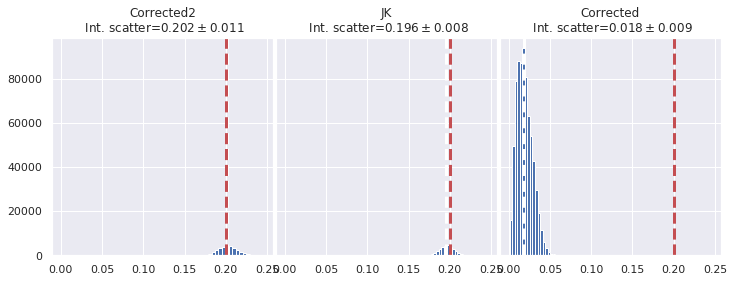

In [93]:
fig, axs = plt.subplots(1,3,figsize=(12,4),sharey=True,sharex=True)
fig.subplots_adjust(wspace=0.01)

for i,err_type in enumerate(['Corrected2','JK','Corrected']):
    out = get_posterior(data, name, err_type)
    pi = out[-1]
    axs[i].hist(pi,bins=21)
    axs[i].axvline(np.median(pi),ls='--',lw=3,color='w')
    axs[i].set_title(err_type+'\n Int. scatter='+get_title(pi))
    
    axs[i].axvline(true['Int. Scatter'],ls='--',lw=3,color='r')

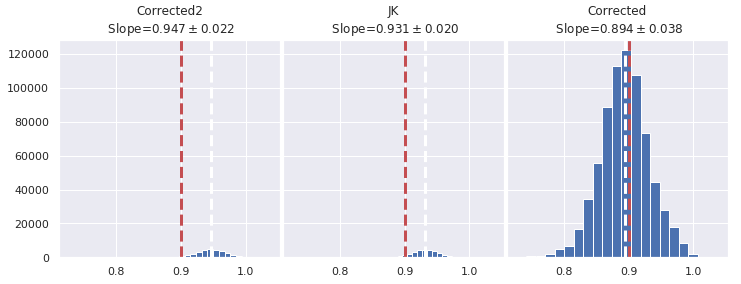

In [94]:
fig, axs = plt.subplots(1,3,figsize=(12,4),sharey=True,sharex=True)
fig.subplots_adjust(wspace=0.01)

for i,err_type in enumerate(['Corrected2','JK','Corrected']):
    out = get_posterior(data, name, err_type)
    pi = out[1]
    axs[i].hist(pi,bins=21)
    axs[i].axvline(np.median(pi),ls='--',lw=3,color='w')
    axs[i].set_title(err_type+'\n Slope='+get_title(pi))
    
    axs[i].axvline(true['beta'],ls='--',lw=3,color='r')

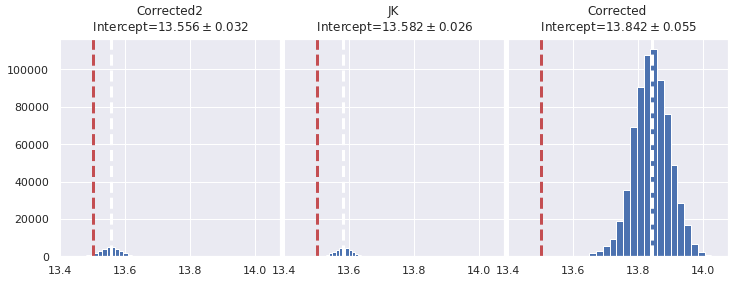

In [95]:
fig, axs = plt.subplots(1,3,figsize=(12,4),sharey=True,sharex=True)
fig.subplots_adjust(wspace=0.01)

for i,err_type in enumerate(['Corrected2','JK','Corrected']):
    out = get_posterior(data, name, err_type)
    pi = out[0]
    axs[i].hist(pi,bins=21)
    axs[i].axvline(np.median(pi),ls='--',lw=3,color='w')
    axs[i].set_title(err_type+'\n Intercept='+get_title(pi))
    
    axs[i].axvline(true['alpha'],ls='--',lw=3,color='r')

In [25]:
import matplotlib

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    #cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(-.5, data.shape[1], 1))
    ax.set_yticks(np.arange(-.5, data.shape[0], 1))
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)


    # Let the horizontal axes labeling appear on top.
#     ax.tick_params(top=True, bottom=False,
#                    labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
#     plt.setp(ax.get_xticklabels(), ha="left",
#              rotation_mode="anchor")

    # Turn spines off and create white grid.
    #ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts